In [1]:
using PyCall
using PyPlot

@pyimport sys
pushfirst!(PyVector(pyimport("sys")["path"]), "/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia")

@pyimport cmb_make_file as cmb_make
@pyimport data_m_make as m_make

include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/make_data_m.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/Delta_map.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/Delta_map_alpha.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/cov_mat_calc.jl")
include("/Users/ikumakiyoshi/Library/Mobile Documents/com~apple~CloudDocs/study_fg_rm/program/Deltamap_test/julia_delta-map/function_julia/calc_noise.jl")

Using CAMB 1.5.2 installed at /Users/ikumakiyoshi/.julia/conda/3/lib/python3.10/site-packages/camb


calc_noise_cov_mat (generic function with 1 method)

In [2]:
random_seed_cmb = 5123
seed_syn = 12345
nside = 4

r =0.01

cmb_data = cmb_make.cmb_make_file(nside, r, random_seed_cmb, seed_syn);
cl_scal, cl_tens = cmb_make.cmb_cl_calc(nside, random_seed_cmb, seed_syn);

In [3]:
# ここミスった
cl_scal_EE = cl_scal[:,2][1:2*nside+1]
cl_scal_BB = cl_scal[:,3][1:2*nside+1]
cl_tens_EE = cl_tens[:,2][1:2*nside+1]
cl_tens_BB = cl_tens[:,3][1:2*nside+1];

In [4]:
@time cov_mat_scal = calc_cmb_cov_mat(cl_scal_EE, cl_scal_BB, nside)
@time cov_mat_tens = calc_cmb_cov_mat(cl_tens_EE, cl_tens_BB, nside);

  3.339812 seconds (19.48 M allocations: 3.107 GiB, 10.85% gc time, 72.87% compilation time)
  0.874932 seconds (13.03 M allocations: 2.694 GiB, 24.67% gc time)


In [5]:
cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r);

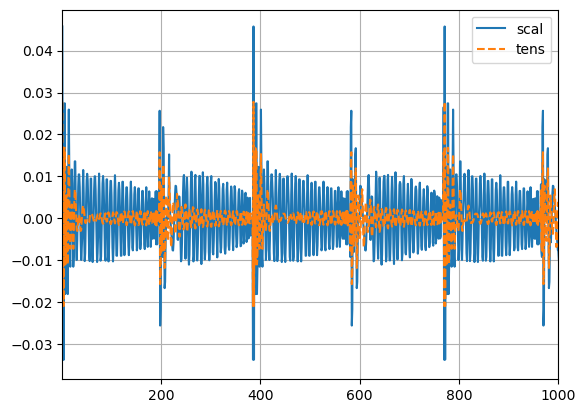

PyObject <matplotlib.legend.Legend object at 0x2868d66b0>

In [6]:
using PyPlot

len = 1:1:147456

PyPlot.plot(len, cov_mat_scal[:], label = "scal")
PyPlot.plot(len, cov_mat_tens[:], label = "tens", linestyle = "dashed")
PyPlot.grid()
PyPlot.xlim(1, 1000)
PyPlot.legend()

In [7]:
freq_band = [40, 50, 100, 140, 280, 402]
#freq_band = [40, 100, 140]
which_model = "d1 and s1"

beta_s, freq_bs, freq_bd, beta_d, T_d = -3, 23*10^9, 353*10^9, 1.5, 20.1

Q, U, x = calc_x_pra(freq_band, 140, nside, cmb_data, "d1 and s1", freq_bs, beta_s, freq_bd, beta_d, T_d);

In [8]:
@time calc_x_pra(freq_band, 140, nside, cmb_data, "d1 and s1", freq_bs, beta_s, freq_bd, beta_d, T_d);

  0.003063 seconds (800 allocations: 262.984 KiB)


In [9]:
noise_seed = [1, 2, 3]
pol_sen = 0.2 # μK
nside = 4

art_noise_cov_mat =  calc_noise_cov_mat(pol_sen, nside, noise_seed);
art_noise_map, sigma = calc_noise_map(pol_sen, nside, noise_seed);

In [10]:
cholesky_logdet(cov_mat + art_noise_cov_mat)

-4640.168000461168

In [11]:
noise_map = [art_noise_map[1]; art_noise_map[2]];

In [12]:
like_array = []

r_in = 0:1e-3:1

#setprecision(BigFloat, 100) 

Q, U, x = calc_x_pra(freq_band, 140, nside, cmb_data, "d1 and s1", freq_bs, beta_s, freq_bd, beta_d, T_d);

for r_pre in r_in
    
    cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, r_pre) + art_noise_cov_mat

    x_with_noise = x + noise_map

    #det_C = log_det(cov_mat)

    # コレスキー ver
    det_C = cholesky_logdet(cov_mat)
    
    push!(like_array, x_with_noise' / cov_mat * x_with_noise + det_C)

    #================python======================#
    #cov_mat_py = calc_all_cov_mat(cov_mat_scal_py, cov_mat_tens_py, r_pre) + art_noise_cov_mat
    #det_C = cholesky_logdet(cov_mat_py)
    #push!(like_array, x_with_noise' / cov_mat_py * x_with_noise  + det_C)
    
    # big float
    #push!(like_array, big.(x)' / big.(cov_mat) * big.(x) + big.(det_C))

end

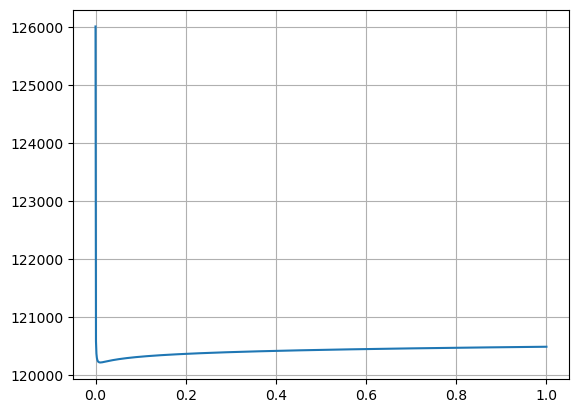

In [13]:
using PyPlot
PyPlot.plot(r_in, like_array)
PyPlot.grid()

In [14]:
r_in[argmin(like_array)]

0.011

In [15]:
chi_sq_array = []

Td_in = 17:1e-1:22

cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, 0.01) + art_noise_cov_mat

#setprecision(BigFloat, 100) 

for Td_pre in Td_in

    Q, U, x = calc_x_pra(freq_band, 140, nside, cmb_data, "d1 and s1", freq_bs, beta_s, freq_bd, beta_d, Td_pre);
    
    x = x + noise_map

    push!(chi_sq_array, x' / cov_mat * x)

    #push!(like_array, big.(x)' / big.(cov_mat) * big.(x) + big.(det_C))
end

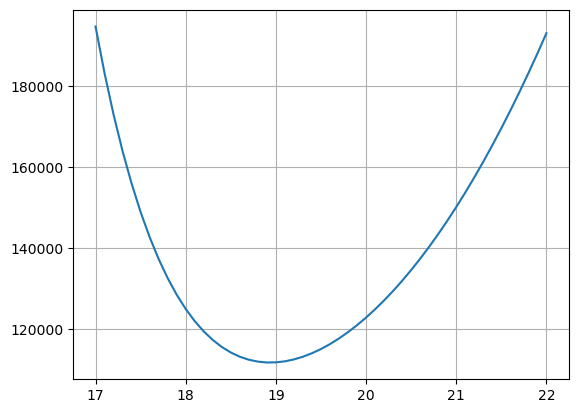

In [17]:
fig = ()
PyPlot.plot(Td_in, chi_sq_array)
PyPlot.grid()

In [19]:
chi_sq_array
Td_in[argmin(chi_sq_array)]

18.9

In [20]:
chi_sq_array = []

beta_d_in = 1:1e-2:2

cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, 0.01) + art_noise_cov_mat

#setprecision(BigFloat, 100) 

for beta_d_pre in beta_d_in

    Q, U, x = calc_x_pra(freq_band, 140, nside, cmb_data, "d1 and s1", freq_bs, beta_s, freq_bd, beta_d_pre, T_d);
    
    x = x + noise_map

    push!(chi_sq_array, x' / cov_mat * x)

    #push!(like_array, big.(x)' / big.(cov_mat) * big.(x) + big.(det_C))
end

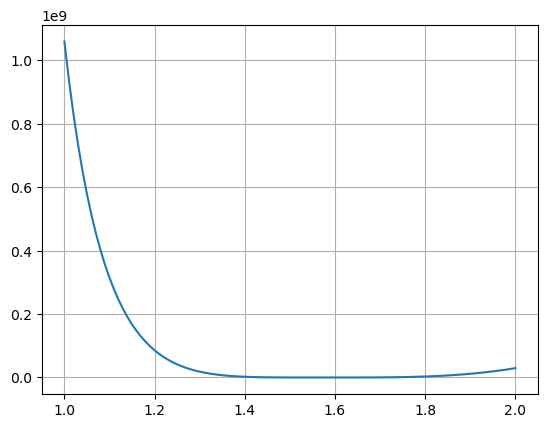

In [22]:
fig = ()
PyPlot.plot(beta_d_in, chi_sq_array)
PyPlot.grid()

In [23]:
chi_sq_array
beta_d_in[argmin(chi_sq_array)]

1.61

In [28]:
chi_sq_array = []

beta_s_in = -4:1e-2:-2

cov_mat = calc_all_cov_mat(cov_mat_scal, cov_mat_tens, 0.01) + art_noise_cov_mat

#setprecision(BigFloat, 100) 

for beta_s_pre in beta_s_in

    Q, U, x = calc_x_pra(freq_band, 140, nside, cmb_data, "d1 and s1", freq_bs, beta_s_pre, freq_bd, beta_d, T_d);
    
    x = x + noise_map

    push!(chi_sq_array, x' / cov_mat * x)

    #push!(like_array, big.(x)' / big.(cov_mat) * big.(x) + big.(det_C))
end

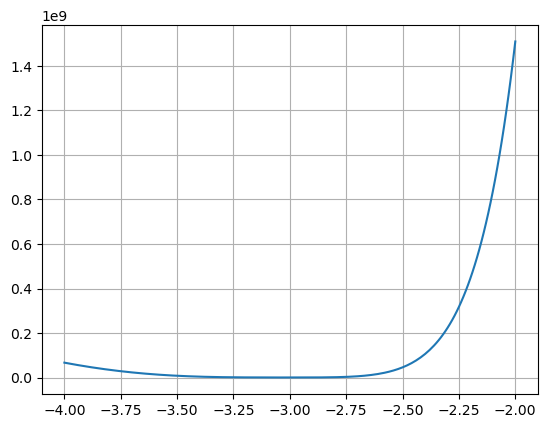

In [29]:
fig = ()
PyPlot.plot(beta_s_in, chi_sq_array)
PyPlot.grid()

In [30]:
chi_sq_array
beta_s_in[argmin(chi_sq_array)]

-2.99